In [95]:
import pandas as pd
import matplotlib.pyplot  as plt
import os

In [96]:
data = pd.read_csv("iiot_30min_norm.csv")

In [97]:
def data_split(ts, train_percentage=0.67):
    timeseries = ts
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test

In [98]:
ts = data["FM1"].to_numpy()

In [99]:
main_data, validate_data = data_split(ts,0.8)

In [100]:
train, test = data_split(main_data,0.8)

In [101]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [102]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [103]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [104]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
model.double()

EPOCHS = 20

In [105]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [106]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 0.1018, test RMSE 0.0888
Epoch 10: train RMSE 0.0680, test RMSE 0.0387


In [107]:
model.eval()

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [108]:
torch.save(model, f"./lstm_forecast_{EPOCHS}_epochs.pth")

In [109]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [110]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
    # shift train predictions for plotting
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1, :]
        # shift test predictions for plotting
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1, :]

    plt.rcParams["figure.figsize"] = [12, 7]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

In [111]:
y_pred_train = model(X_train)

In [112]:
print("Значения метрик на тренеровачных данных")
validate(y_train,y_pred_train.detach())

Значения метрик на тренеровачных данных
MSE: 0.0025099298268966216
RMSE: 0.050099199862838346
MAE: 0.01802710013066205
MAPE: inf
R2: 0.8041061516179684


In [113]:
y_pred_test = model(X_test)

In [114]:
print("Значения метрик на тестовых данных")
validate(y_test,y_pred_test.detach())

Значения метрик на тестовых данных
MSE: 0.00010845812432689106
RMSE: 0.01041432303737939
MAE: 0.009145873339846828
MAPE: 2.6219445607842484
R2: 0.754809144971039


In [115]:
X_valid, y_valid = create_dataset(validate_data,1)

In [116]:
y_pred_valid = model(y_valid)

In [117]:
print("Метрики на валидационных данных")
validate(y_valid,y_pred_valid.detach())

Метрики на валидационных данных
MSE: 0.00025297283864313114
RMSE: 0.0159051198877321
MAE: 0.013545261991605743
MAPE: 3.5998818314028376
R2: 0.9853304277581879


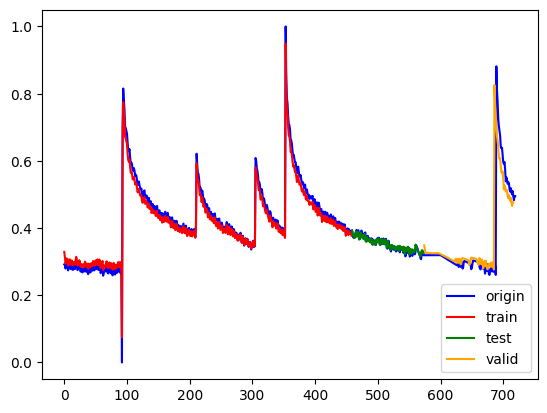

In [118]:
plt.plot(ts,color="blue",label="origin")
plt.plot(np.arange(len(y_pred_train.detach())),y_pred_train.detach(),color="red",label="train")
plt.plot(np.arange(len(y_pred_train.detach()),len(y_pred_train.detach()) + len(y_pred_test.detach())),y_pred_test.detach(),color="green",label="test")
plt.plot(np.arange(len(y_pred_train.detach()) + len(y_pred_test.detach()),len(y_pred_train.detach()) + len(y_pred_test.detach()) + len(y_pred_valid.detach())),y_pred_valid.detach(),color="orange",label="valid")
plt.legend()